## インポート

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.random.seed(1234)

## データの読み込み

In [2]:
df = pd.read_csv('chap05/input/data3a.csv')
df.head()

,y,x,f
0,6,8.31,C
1,6,9.44,C
2,6,9.50,C
3,12,9.07,C
4,10,10.16,C


In [8]:
df.shape
df.f = df.f.replace(to_replace=['C','T'], value=[0, 1])

## サンプルデータの散布図行列

In [4]:
class Dispatcher(object):
    
    def __init__(self, fontsize=20, alpha=0.6, cmap='RdBu', threshold=5):
        self.fontsize = fontsize
        self.alpha = alpha
        self.cmap = plt.get_cmap(cmap)
 
        # 離散値 / 連続値とみなす閾値
        self.threshold = threshold
        
    def comb(self, x_series, y_series, label=None, color=None):
        """ 下三角部分のプロット """       

        x_nunique = x_series.nunique()
        y_nunique = y_series.nunique()

        if x_nunique < self.threshold and y_nunique < self.threshold:
            # 離散値 x 離散値のプロット
            return self._dd_plot(x_series, y_series, label=label, color=color)
        
        elif x_nunique < self.threshold or y_nunique < self.threshold:
            # 離散値 x 連続値のプロット
             return self._dc_plot(x_series, y_series, label=label, color=color)
            
        else:
            # 連続値 x 連続値のプロット
            return plt.scatter(x_series, y_series, label=label, color=color)

    def _dd_plot(self, x_series, y_series, label=None, color=None):
        """ 離散値 x 離散値のプロット """

        # x, y 各組み合わせの個数を集計
        total = y_series.groupby([x_series, y_series]).count()

        # x, y軸をプロットする位置を取得
        xloc = total.index.labels[0] 
        yloc = total.index.labels[1] 
        values = total.values

        ax = plt.gca()
        for xp, yp, vp in zip(xloc, yloc, values):
            ax.annotate(vp, (xp, yp), fontsize=self.fontsize,
                        ha='center', va='center')

        # 組み合わせの個数を散布図としてプロット
        size = values / (values.max() * 1.1) * 100 * 20
        ax.scatter(xloc, yloc, s=size, label=label, color=color)
        ax.set_ylim(yloc[0] - 0.5, yloc[-1] + 0.5)
        
    def _dc_plot(self, x_series, y_series, label=None, color=None):
        """ 離散値 x 連続値のプロット """

        if y_series.nunique() < x_series.nunique():
            # y軸が離散値の場合は、x, yを入替
            # 水平方向に箱ひげ図をプロット
            x_series, y_series = y_series, x_series
            vert = False
        else:
            vert = True

        xlab, xun = pd.factorize(x_series)

        # 箱ひげ図用のデータの準備
        data = []
        for i, g in y_series.groupby(xlab):
            data.append(g) 
            
        ax = plt.gca()
        ax.boxplot(data, positions=np.arange(len(data)), vert=vert)

        # 散布図をプロット
        xloc = xlab + np.random.normal(scale=0.05, size=len(xlab))
        if not vert:
            y_series, xloc = xloc, y_series

        ax.scatter(xloc, y_series, label=label, color=color,
                   alpha=self.alpha)
   
    def diag(self, series, label=None, color=None):
        """ 対角部分のプロット """

        ax = series.plot.hist()
        ax = series.plot.kde(grid=False, ax=ax.twinx())
        ax.yaxis.set_visible(False)

    def ellipse(self, x_series, y_series, label=None, color=None):
        """ 上三角部分のプロット """        

        from matplotlib.patches import Ellipse
        
        # 相関係数を楕円としてプロット
        r = x_series.corr(y_series)
        c = self.cmap(0.5 * (r + 1))

        ax = plt.gca()
        ax.axis('off')
        ax.add_artist(Ellipse(xy=[.5, .5], width=np.sqrt(1 + r), height=np.sqrt(1 - r),
                              angle=45, facecolor=c, edgecolor='none', transform=ax.transAxes))
        ax.text(.5, .5, '{:.0f}'.format(r * 100), fontsize=self.fontsize,
                ha='center', va='center', transform=ax.transAxes)

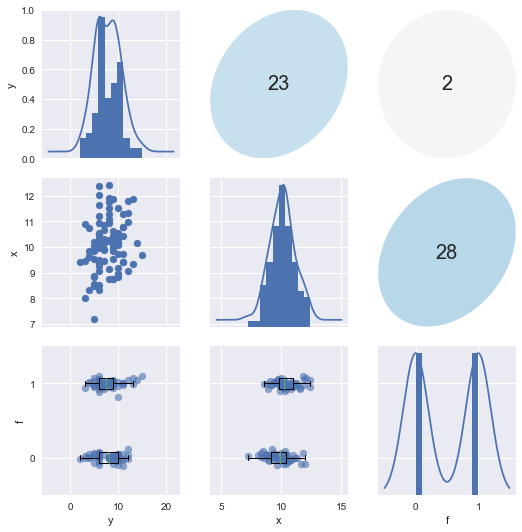

In [9]:
g = sns.PairGrid(df, diag_sharey=False)

d = Dispatcher()
# 対角成分
g.map_diag(d.diag)
# 下三角成分
g.map_lower(d.comb);
# 上三角成分
g.map_upper(d.ellipse);

## モデル式の記述

$\lambda[n] = exp(\beta_1 + \beta_2 X[n] + \beta_3 F[n]) $

$Y[n]$ ~ $ Poisson( \lambda[n] )$

## Stanでの実装

In [23]:
model_code="""
data {
  int N;
  real X[N];
  int<lower=0, upper=1> F[N];
  int<lower=0> Y[N];
}
parameters {
  real b1;
  real b2;
  real b3;
}
transformed parameters {
  real lambda[N];
  for (n in 1:N)
    lambda[n] = exp(b1 + b2*X[n] + b3*F[n]);
}
model {
  for (n in 1:N)
    Y[n] ~ poisson(lambda[n]);
}
generated quantities {
  real y_pred[N];
  for (n in 1:N)
    y_pred[n] = poisson_rng(lambda[n]);
}
"""

df['x_norm'] = (df.x - df.x.mean()) /df.x.std()

from pystan import StanModel
data = dict(N=df.shape[0], X=df['x_norm'], F=df.f, Y=df.y)
sm = StanModel(model_code=model_code)

fit = sm.sampling(data=data, n_jobs=1, seed=123)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_efb3d757bc2e815e58bb94666aa98965 NOW.


Inference for Stan model: anon_model_efb3d757bc2e815e58bb94666aa98965.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1           2.07  1.1e-3   0.05   1.96   2.03   2.07    2.1   2.17   2095    1.0
b2           0.08  7.2e-4   0.04 5.7e-3   0.06   0.08   0.11   0.15   2659    1.0
b3          -0.03  1.7e-3   0.08  -0.18  -0.08  -0.03   0.02   0.12   2050    1.0
lambda[0]    6.88  9.9e-3   0.54   5.89    6.5   6.86   7.25   7.95   2925    1.0
lambda[1]    7.52  8.2e-3   0.41   6.75   7.24   7.52    7.8   8.33   2450    1.0
lambda[2]    7.56  8.2e-3    0.4   6.79   7.28   7.55   7.83   8.36   2412    1.0
lambda[3]     7.3  8.5e-3   0.44   6.49    7.0   7.29    7.6   8.19   2669    1.0
lambda[4]    7.96  9.1e-3   0.42   7.16   7.68   7.95   8.25   8.77   2081    1.0
lambda[5]    6.89  9.9e-3   0.54    5.9   6.51   6.86   7.25   7.95   292

## traceplot

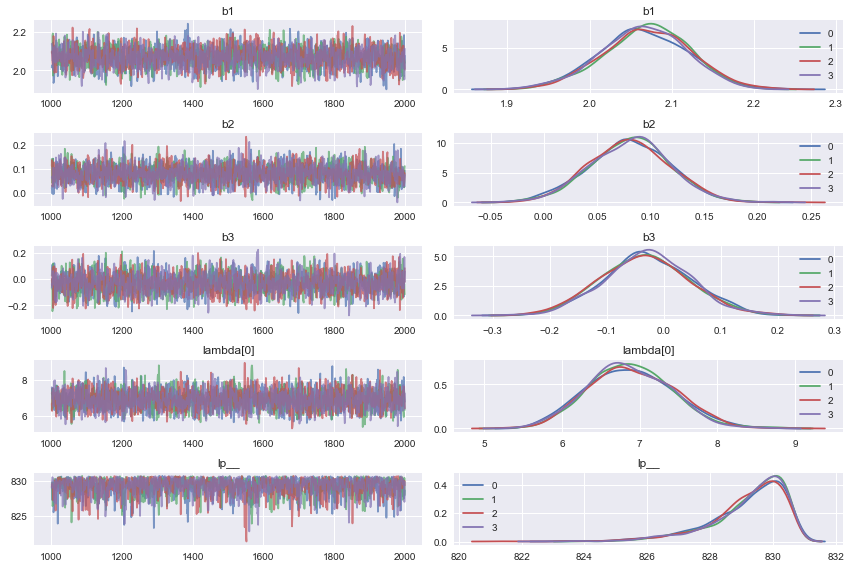

In [24]:
import math

palette = sns.color_palette()
ms = fit.extract(permuted=False, inc_warmup=True)
iter_from = fit.sim['warmup']
iter_range = np.arange(iter_from, ms.shape[0])
paraname = fit.sim['fnames_oi'][:4] #b1, b2, b3, sigma
paraname.append(fit.sim['fnames_oi'][-1]) # 'lp__' もtrace plot に追加
paraname_key = [fit.sim['fnames_oi'].index(paran) for paran in paraname]

gpp = 5 # 画像１枚あたりの縦方向のグラフ数 gpp:graph per page
num_pages = math.ceil(len(paraname)/gpp)  # parameter 数をgppで割った数より大きい最少の整数=画像枚数

for pg in range(num_pages):  # 1ページにgppx2のグラフをプロットする
    plt.figure(figsize=(12,8))
    for pos in range(gpp):
        pi = pg*gpp + pos
        if pi >= len(paraname): break
        # trace plot
        plt.subplot(gpp, 2, 2*pos+1)
        plt.tight_layout()
        [plt.plot(iter_range + 1, ms[iter_range,ci,paraname_key[pi]], color=palette[ci], label=ci, alpha=.7) for ci in range(ms.shape[1])]
        
        plt.title(paraname[pi])
        # posterior distribution 
        plt.subplot(gpp, 2, 2*(pos+1))
        plt.tight_layout()
        [sns.kdeplot(ms[iter_range,ci,paraname_key[pi]], color=palette[ci], label=ci) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
        plt.legend()

## 予測区間

In [25]:
ms = fit.extract()

qua = np.percentile(ms['y_pred'], q=[5,50,95], axis=0)
d_qua = pd.DataFrame(qua.T, 
                     columns=['p'+str(p) for p in [5, 50, 95]])
df_pred = df.join(d_qua)

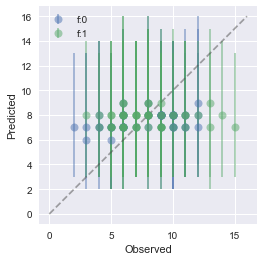

In [29]:
# 実測値と予測値の散布図
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for a, df_sub in df_pred.groupby(by='f'):
    ax.errorbar(x=df_sub.y, y=df_sub.p50, 
                yerr=[df_sub.p50-df_sub['p2.5'], df_sub['p97.5']-df_sub.p50],
                fmt='o', ms=8, alpha=0.5, marker='o', label='f:'+str(a))
ax.legend()
ax.set_aspect('equal')
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.plot([0, 16], [0, 16], ls="--", c=".3", alpha=.5)

plt.show()